# Job Search I: The McCall Search Model

## Contents

- [Job Search I: The McCall Search Model](#Job-Search-I:-The-McCall-Search-Model)  
  - [Overview](#Overview)  
  - [The McCall Model](#The-McCall-Model)  
  - [Computing the Optimal Policy: Take 1](#Computing-the-Optimal-Policy:-Take-1)  
  - [Computing the Optimal Policy: Take 2](#Computing-the-Optimal-Policy:-Take-2)  
  - [Exercises](#Exercises)  


> “Questioning a McCall worker is like having a conversation with an out-of-work friend:
> ‘Maybe you are setting your sights too high’, or ‘Why did you quit your old job before you
> had a new one lined up?’ This is real social science: an attempt to model, to understand,
> human behavior by visualizing the situation people find themselves in, the options they face
> and the pros and cons as they themselves see them.” – Robert E. Lucas, Jr.


In addition to what’s in Anaconda, this lecture will need the following libraries

In [1]:
!pip install quantecon

## Overview

The McCall search model [[McC70]](zreferences.ipynb#mccall1970) helped transform economists’ way of thinking about labor markets

To clarify vague notions such as “involuntary” unemployment, McCall modeled the decision problem of unemployed agents directly, in terms of factors such as

- current and likely future wages  
- impatience  
- unemployment compensation  


To solve the decision problem he used dynamic programming

Here we set up McCall’s model and adopt the same solution method

As we’ll see, McCall’s model is not only interesting in its own right but also an excellent vehicle for learning dynamic programming

Let’s start with some imports

In [2]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import quantecon as qe
from quantecon.distributions import BetaBinomial

## The McCall Model


<a id='index-0'></a>
An unemployed worker receives in each period a job offer at wage $ W_t $

At time $ t $, our worker has two choices:

1. Accept the offer and work permanently at constant wage $ W_t $  
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period  


The wage sequence is assumed to be iid with probability mass function $ \phi $

Thus $ \phi (w) $ is the probability of observing wage offer $ w $ in the set $ w_1, \ldots, w_n $

The worker is infinitely lived and aims to maximize the expected discounted sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t Y_t
$$

The constant $ \beta $ lies in $ (0, 1) $ and is called a **discount factor**

The smaller is $ \beta $, the more the worker discounts future utility relative to current utility

The variable  $ Y_t $ is income, equal to

- his wage $ W_t $ when employed  
- unemployment compensation $ c $ when unemployed  

### A Trade Off

The worker faces a trade-off:

- Waiting too long for a good offer is costly, since the future is discounted  
- Accepting too early is costly, since better offers might arrive in the future  


To decide optimally in the face of this trade off, we use dynamic programming

Dynamic programming can be thought of as a two step procedure that

1. first assigns values to “states” and  
1. then deduces optimal actions given those values  


We’ll go through these steps in turn

### The Value Function

In order to optimally trade off current and future rewards, we need to think about two things:

1. the current payoffs we get from different choices  
1. the different states that those choices will lead to next period (in this case, either employment or unemployment)  


To weigh these two aspects of the decision problem, we need to assign *values* to states

To this end, let $ v^*(w) $ be the total lifetime *value* accruing to an unemployed worker who enters the current period unemployed but with wage offer $ w $ in hand

More precisely, $ v^*(w) $ denotes the value of the objective function [(1)](mccall_model_with_separation.ipynb#equation-objective) when an agent in this situation makes *optimal* decisions now and at all future points in time

Of course $ v^*(w) $ is not trivial to calculate because we don’t yet know what decisions are optimal and what aren’t!

But think of $ v^* $ as a function that assigns to each possible wage $ w $ the maximal lifetime value that can be obtained with that offer in hand

A crucial observation is that this function $ v^* $ must satisfy the recursion


<a id='equation-odu-pv'></a>
$$
v^*(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta \sum_{w'} v^*(w') \phi (w')
    \right\} \tag{1}
$$

for every possible $ w $  in $ w_1, \ldots, w_n $

This important equation is a version of the **Bellman equation**, which is
ubiquitous in economic dynamics and other fields involving planning over time

The intuition behind it is as follows:

- the first term inside the max operation is the lifetime payoff from accepting current offer $ w $, since  


$$
w + \beta w + \beta^2 w + \cdots = \frac{w}{1 - \beta}
$$

- the second term inside the max operation is the **continuation value**, which is the lifetime payoff from rejecting the current offer and then behaving optimally in all subsequent periods  


If we optimize and pick the best of these two options, we obtain maximal lifetime value from today, given current offer $ w $

But this is precisely $ v^*(w) $, which is the l.h.s. of [(1)](#equation-odu-pv)

### The Optimal Policy

Suppose for now that we are able to solve [(1)](#equation-odu-pv) for the unknown
function $ v^* $

Once we have this function in hand we can behave optimally (i.e., make the
right choice between accept and reject)

All we have to do is select the maximal choice on the r.h.s. of [(1)](#equation-odu-pv)

The optimal action is best thought of as a **policy**, which is, in general, a map from
states to actions

In our case, the state is the current wage offer $ w $

Given *any* $ w $, we can read off the corresponding best choice (accept or
reject) by picking the max on the r.h.s. of [(1)](#equation-odu-pv)

Thus, we have a map from $ \mathbb R $ to $ \{0, 1\} $, with 1 meaning accept and 0 meaning reject

We can write the policy as follows

$$
\sigma(w) := \mathbf{1}
    \left\{
        \frac{w}{1 - \beta} \geq c + \beta \sum_{w'} v^*(w') \phi (w')
    \right\}
$$

Here $ \mathbf{1}\{ P \} = 1 $ if statement $ P $ is true and equals 0 otherwise

We can also write this as

$$
\sigma(w) := \mathbf{1} \{ w \geq \bar w \}
$$

where

$$
\bar w := (1 - \beta) \left\{ c + \beta \sum_{w'} v^*(w') \phi (w') \right\}
$$

Here $ \bar w $ is a constant depending on $ \beta, c $ and the wage distribution, called the *reservation wage*

The agent should accept if and only if the current wage offer exceeds the reservation wage

Clearly, we can compute this reservation wage if we can compute the value function

## Computing the Optimal Policy: Take 1

To put the above ideas into action, we need to compute the value function at
points $ w_1, \ldots, w_n $

In doing so, we can identify these values with the vector $ v^* = (v^*_i) $ where $ v^*_i := v^*(w_i) $

In view of [(1)](#equation-odu-pv), this vector satisfies the nonlinear system of equations


<a id='equation-odu-pv2'></a>
$$
v^*_i
= \max \left\{
        \frac{w_i}{1 - \beta}, \, c + \beta \sum_{w'} v^*(w') \phi (w')
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{2}
$$

### The Algorithm

To compute this vector, we proceed as follows:

Step 1: pick an arbitrary initial guess $ v \in \mathbb R^n $

Step 2: compute a new vector $ v' \in \mathbb R^n $ via


<a id='equation-odu-pv2p'></a>
$$
v'_i
= \max \left\{
        \frac{w_i}{1 - \beta}, \, c + \beta \sum_{j} v_j \phi (w_j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{3}
$$

Step 3: calculate a measure of the deviation between $ v $ and $ v' $, such as $ \max_i |v_i - v_i'| $

Step 4: if the deviation is larger than some fixed tolerance, set $ v = v' $ and go to step 2, else continue

Step 5: return $ v $

This algorithm returns an arbitrarily good approximation to the true solution
to [(2)](#equation-odu-pv2), which represents the value function

(Arbitrarily good means here that the approximation converges to the true
solution as the tolerance goes to zero)

### The Fixed Point Theory

What’s the math behind these ideas?

First, one defines a mapping $ T $ from $ \mathbb R^n $ to
itself via


<a id='equation-odu-pv3'></a>
$$
Tv'_i
= \max \left\{
        \frac{w_i}{1 - \beta}, \, c + \beta \sum_{j} v_j \phi (w_j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{4}
$$

(A new vector $ Tv $ is obtained from given vector $ v $ by evaluating
the r.h.s. at each $ i $)

One can show that the conditions of the Banach contraction mapping theorem are
satisfied by $ T $ as a self-mapping on $ \mathbb R^n $

One implication is that $ T $ has a unique fixed point in $ \mathbb R^n $

Moreover, it’s immediate from the definition of $ T $ that this fixed
point is precisely the value function

The iterative algorithm presented above corresponds to iterating with
$ T $ from some initial guess $ v $

The Banach contraction mapping theorem tells us that this iterative process
generates a sequence that converges to the fixed point

### Implementation

Here’s the distribution of wage offers we’ll work with

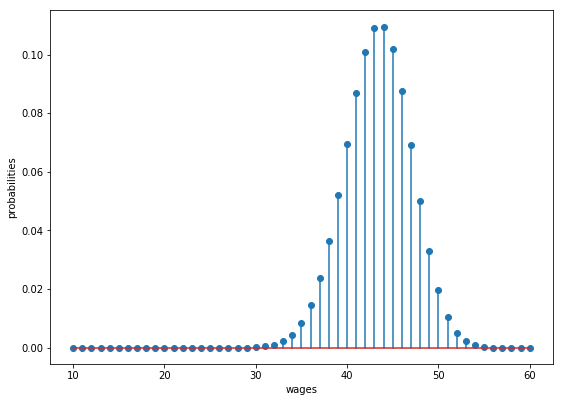

In [3]:
n, a, b = 50, 200, 100
w_min, w_max = 10, 60
w_vals = np.linspace(w_min, w_max, n+1)
dist = BetaBinomial(n, a, b)
ϕ_vals = dist.pdf()

fig, ax = plt.subplots(figsize=(9, 6.5))
ax.stem(w_vals, ϕ_vals, label='$\phi (w\')$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

First let’s have a look at the sequence of approximate value functions that
the algorithm above generates

Default parameter values are embedded in the function

Our initial guess $ v $ is the value of accepting at every given wage

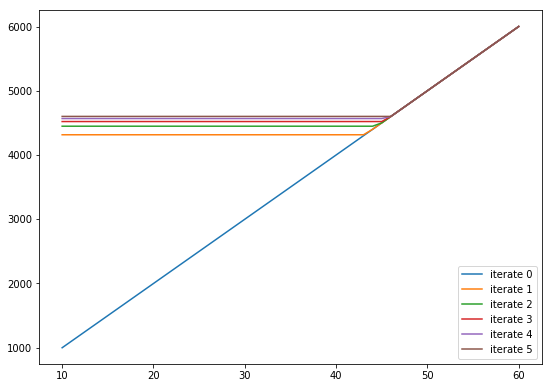

In [4]:
def plot_value_function_seq(ax,
                            c=25,
                            β=0.99,
                            w_vals=w_vals,
                            ϕ_vals=ϕ_vals,
                            num_plots=6):

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(w_vals, v, label=f"iterate {i}")
        # Update guess
        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)
        v[:] = v_next

    ax.legend(loc='lower right')


fig, ax = plt.subplots(figsize=(9, 6.5))
plot_value_function_seq(ax)
plt.show()

Here’s more serious iteration effort, that continues until measured deviation
between successive iterates is below tol

We’ll be using JIT compilation via Numba to turbo charge our loops

In [5]:
@jit(nopython=True)
def compute_reservation_wage(c=25,
                             β=0.99,
                             w_vals=w_vals,
                             ϕ_vals=ϕ_vals,
                             max_iter=500,
                             tol=1e-6):

    # == First compute the value function == #

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * ϕ_vals)
            v_next[j] = max(stop_val, cont_val)

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * ϕ_vals))

Let’s compute the reservation wage at the default parameters

In [6]:
compute_reservation_wage()

47.316499710024964

### Comparative Statics

Now we know how to compute the reservation wage, let’s see how it varies with
parameters

In particular, let’s look at what happens when we change $ \beta $ and
$ c $

In [7]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        R[i, j] = compute_reservation_wage(c=c, β=β)

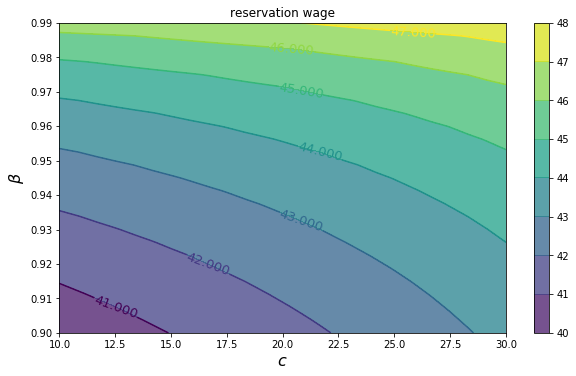

In [8]:
fig, ax = plt.subplots(figsize=(10, 5.7))

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

As expected, the reservation wage increases both with patience and with
unemployment compensation

## Computing the Optimal Policy: Take 2

The approach to dynamic programming just described is very standard and
broadly applicable

For this particular problem, there’s also an easier way, which circumvents the
need to compute the value function

Let $ h $ denote the value of not accepting a job in this period but
then behaving optimally in all subsequent periods

That is,


<a id='equation-j1'></a>
$$
h
= c + \beta
    \sum_{w'} v^*(w') \phi (w')
\quad \tag{5}
$$

where $ v^* $ is the value function

By the Bellman equation, we then have

$$
v^*(w')
= \max \left\{ \frac{w'}{1 - \beta}, \, h \right\}
$$

Substituting this last equation into [(5)](#equation-j1) gives


<a id='equation-j2'></a>
$$
h
= c + \beta
    \sum_{w'}
    \max \left\{
        \frac{w'}{1 - \beta}, h
    \right\}  \phi (w')
\quad \tag{6}
$$

This is a nonlinear equation that we can solve for $ h $

The natural solution method for this kind of nonlinear equation is iterative

That is,

Step 1: pick an initial guess $ h $

Step 2: compute the update $ h' $ via


<a id='equation-j3'></a>
$$
h'
= c + \beta
    \sum_{w'}
    \max \left\{
        \frac{w'}{1 - \beta}, h
    \right\}  \phi (w')
\quad \tag{7}
$$

Step 3: calculate the deviation $ |h - h'| $

Step 4: if the deviation is larger than some fixed tolerance, set $ h = h' $ and go to step 2, else continue

Step 5: return $ h $

Once again, one can use the Banach contraction mapping theorem to show that this process always converges

The big difference here, however, is that we’re iterating on a single number, rather than an $ n $-vector

Here’s an implementation:

In [9]:
@jit(nopython=True)
def compute_reservation_wage_two(c=25,
                                 β=0.99,
                                 w_vals=w_vals,
                                 ϕ_vals=ϕ_vals,
                                 max_iter=500,
                                 tol=1e-5):

    # == First compute ϕ == #

    h = np.sum(w_vals * ϕ_vals) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w_vals / (1 - β), h)
        h_next = c + β * np.sum(s * ϕ_vals)

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

You can use this code to solve the exercise below

## Exercises

### Exercise 1

Compute the average duration of unemployment when $ \beta=0.99 $ and
$ c $ takes the following values

> `c_vals = np.linspace(10, 40, 25)`


That is, start the agent off as unemployed, computed their reservation wage
given the parameters, and then simulate to see how long it takes to accept

Repeat a large number of times and take the average

Plot mean unemployment duration as a function of $ c $ in `c_vals`